In [ ]:
!pip install dataheroes

In [ ]:
from dataheroes.utils import activate_account
activate_account("abhipsha3013@gmail.com")

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
import datetime
import random
from time import time

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_covtype
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from dataheroes import CoresetTreeServiceLG

In [ ]:
# Load Covertype dataset as a pandas data frame.
# In the output data frame all columns are features beside the last column.
# The last column (Cover_Type) is the target
df = fetch_covtype(as_frame=True).frame

# Split dataset: test=30%, train=70% (train_1=3/4 of the train dataset, tran_2=1/4 of the train dataset)
train, test = train_test_split(df, test_size=0.3, random_state=42)
train_1, train_2 = train_test_split(train, test_size=1/4, random_state=42)

# Prepare the data directory and set the file names.
data_dir = Path("Data")
data_dir.mkdir(parents=True, exist_ok=True)
train_1_file_path = data_dir / "train_1.csv"
train_2_file_path = data_dir / "train_2.csv"
test_file_path = data_dir / "test.csv"

# Store datasets as CSV.
# We use the data frame index as the unique identifier and define a column for it (index_column)
# Defining an index column is optional. In this example we set it to have a reference to the original dataset.
train_1.to_csv(train_1_file_path, index_label="index_column")
train_2.to_csv(train_2_file_path, index_label="index_column")
test.to_csv(test_file_path, index_label="index_column")

In [ ]:
# Tell the tree how the data is structured.
# In this example we have an index column, a target column and a property column.
# Property is a column you can filter on, but it isn't taken into account when building
# the coreset or training the model.
# All other columns are features.

start_time = time()
data_params = {
    'target': {'name': 'Cover_Type'},
    'index': {'name': 'index_column'}
}
# Initialize the service and build the tree.
# The tree uses the local file system to store its data.
# After this step you will have a new directory .dataheroes_cache
service_obj = CoresetTreeServiceLG(data_params=data_params,
                                   optimized_for=['training', 'cleaning'],
                                   n_classes=7,
                                   n_instances=305_000,
                                  )
service_obj.build_from_file(train_1_file_path)

print(f"Coreset Build time (sec) {round(time()-start_time, 2)}")

Coreset Build time (sec) 28.65


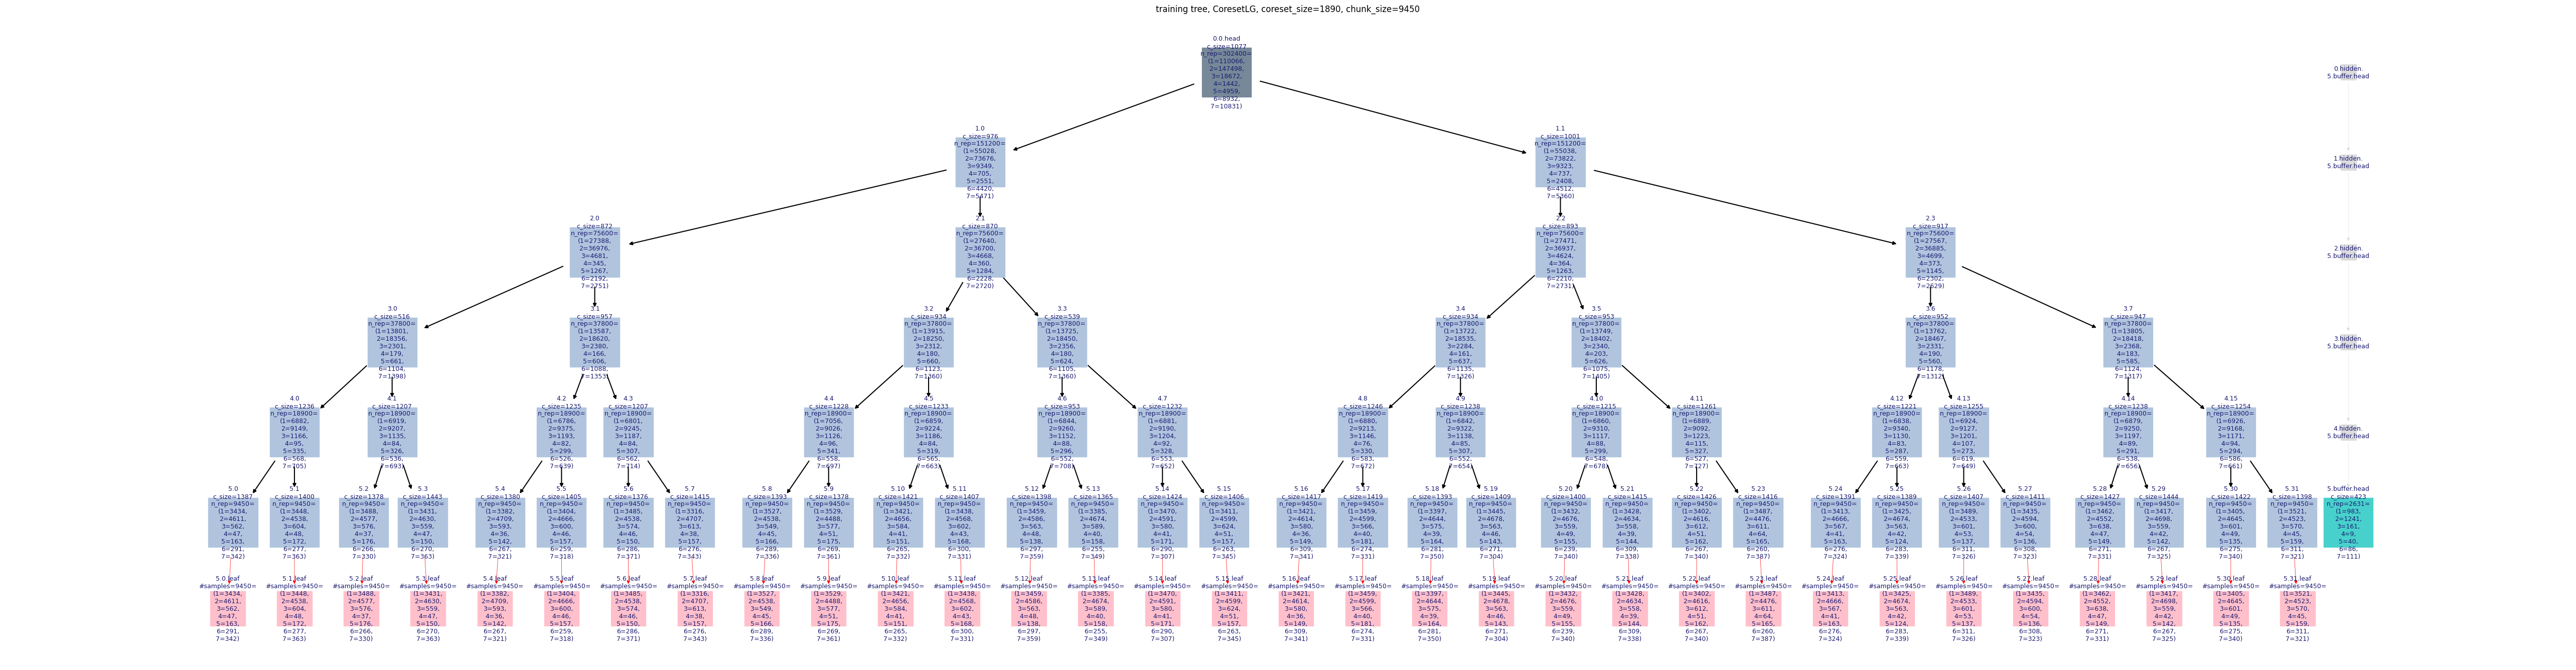

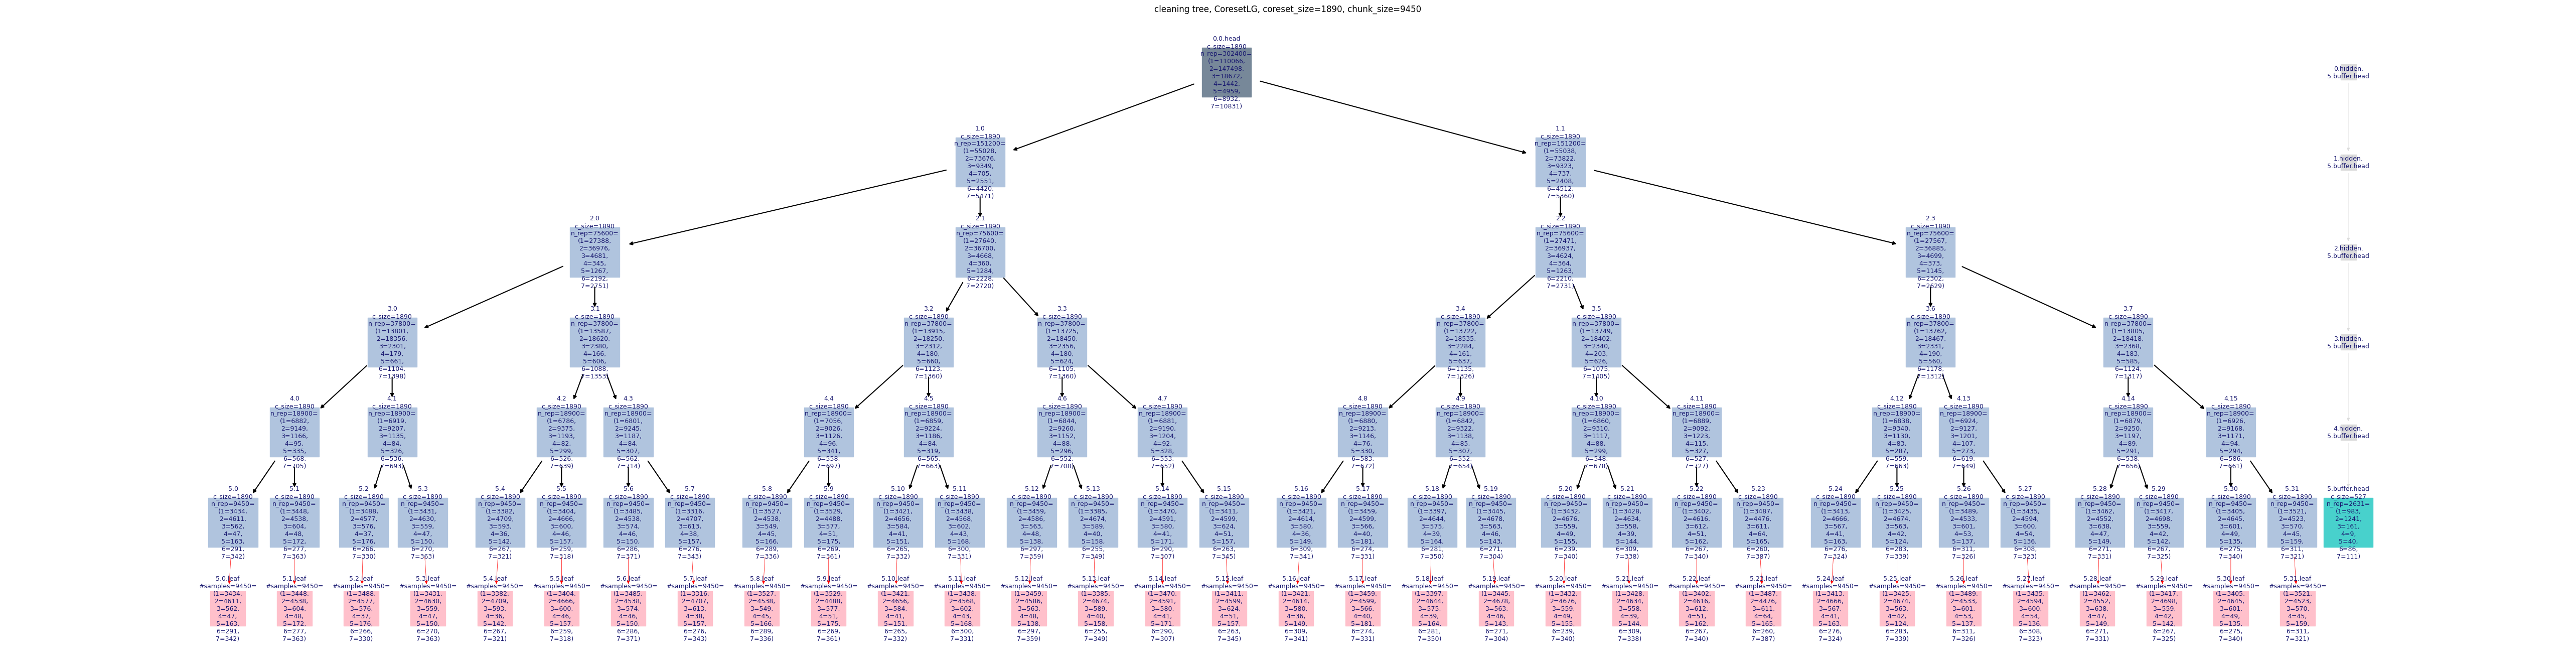

In [ ]:
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)
plot_paths = service_obj.plot(output_dir)

In [ ]:
# Ignore convergence warnings for logistic regression
#from sklearn.exceptions import ConvergenceWarning
#warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Get the top level coreset (~2K samples with weights)
start_time = time()
coreset = service_obj.get_coreset()
indices, X, y = coreset['data']
w = coreset['w']
# Train a logistic regression model on the coreset.
coreset_model = LogisticRegression(max_iter=250).fit(X, y, sample_weight=w)
n_samples_coreset = len(y)
print(f"Coreset train time (sec) {round(time()-start_time, 2)}")

Coreset train time (sec) 1.08


In [ ]:
X = train_1.iloc[:, 0:-1].to_numpy()
y = train_1.iloc[:, -1].to_numpy()

start_time = time()
full_dataset_model = LogisticRegression(max_iter=250).fit(X, y)
n_samples_full = len(y)
print(f"Full dataset train time (sec) {round(time()-start_time, 2)}")

Full dataset train time (sec) 64.74


In [ ]:
# Read test dataset from file
X_test = test.iloc[:, 0:-1].to_numpy()
y_test = test.iloc[:, -1].to_numpy()

# Evaluate model
coreset_score = roc_auc_score(y_test, coreset_model.predict_proba(X_test), multi_class='ovr')
full_dataset_score = roc_auc_score(y_test, full_dataset_model.predict_proba(X_test), multi_class='ovr')

print(f"Coreset AUC score ({n_samples_coreset:,} samples): {round(coreset_score,3)}")
print(f"Full dataset AUC score ({n_samples_full:,} samples): {round(full_dataset_score,3)}")

Coreset AUC score (1,500 samples): 0.843
Full dataset AUC score (305,031 samples): 0.849


In [ ]:
out_dir = Path('output')
out_dir.mkdir(exist_ok=True)
save_tree_name = 'train_1_coreset_tree'
save_path = service_obj.save(out_dir, save_tree_name, override=True)

In [ ]:
service_obj = CoresetTreeServiceLG.load(out_dir, save_tree_name)

In [ ]:
start_time = time()
service_obj.partial_build_from_file(train_2_file_path)
print(f"Coreset partial build time (sec) {round(time()-start_time, 2)}")


Coreset partial build time (sec) 8.41


In [ ]:
# There are 7 classes, we choose the biggest one, that is 2
start_time = time()
biggest_class = 2
number_important_samples = 100
important_samples = service_obj.get_cleaning_samples(class_size={biggest_class: number_important_samples})
print(f"Coreset get cleaning samples time (sec) {round(time()-start_time, 2)}")

Coreset get cleaning samples time (sec) 1.04


In [ ]:
# take first 5 samples for update (0..4)
indexes_for_update_targets = np.arange(0,5)
# updating target with different values (not equal 2)
y_new = [1, 3, 4, 7, 7]
# update selected samples on the coreset tree
start_time = time()
service_obj.update_targets(important_samples['idx'][indexes_for_update_targets], y_new)
print(f"Coreset update targets time (sec) {round(time()-start_time, 2)}")

# Same update on full dataset
train.loc[important_samples['idx'][indexes_for_update_targets], 'Cover_Type'] = y_new

Coreset update targets time (sec) 5.96


In [ ]:
# take next 5 samples for update (5..9)
indexes_for_update_features = np.arange(5,10)
X_new = important_samples['X'][indexes_for_update_features]
# modify X, as a simple example - set all binary fields = 1
for sample in X_new:
    sample[sample == 0] = 1
# update selected samples on the coreset tree
start_time = time()
service_obj.update_features(important_samples['idx'][indexes_for_update_features], X_new)
print(f"Coreset update features time (sec) {round(time()-start_time, 2)}")

# same features updated on full dataset
train.loc[important_samples['idx'][indexes_for_update_features], train.columns[0:-1]] = X_new

Coreset update features time (sec) 4.78


In [ ]:
# take next 5 samples for remove (10..14)
indexes_for_remove = np.arange(10,15)
# remove selected samples from the coreset tree
start_time = time()
service_obj.remove_samples(important_samples['idx'][indexes_for_remove])
print(f"Coreset remove samples time (sec) {round(time()-start_time, 2)}")

# remove same samples from full dataset
train = train.drop(train.loc[important_samples['idx'][indexes_for_remove]].index)

Coreset remove samples time (sec) 10.66


In [ ]:
start_time = time()
service_obj.fit(max_iter=250)
n_samples_coreset = len(service_obj.get_coreset()['w'])
print(f"Coreset fit time (sec) {round(time()-start_time, 2)}")

Coreset fit time (sec) 3.04


In [ ]:
X = train.iloc[:, 0:-1].to_numpy()
y = train.iloc[:, -1].to_numpy()

start_time = time()
full_updated_dataset_model = LogisticRegression(max_iter=250).fit(X, y)
n_samples_full = len(y)
print(f"Full dataset fit time (sec) {round(time()-start_time, 2)}")

Full dataset fit time (sec) 84.77


In [ ]:
final_tree_lg_score = roc_auc_score(y_test, service_obj.predict_proba(X_test), multi_class='ovr')
full_updated_dataset_score = roc_auc_score(y_test, full_updated_dataset_model.predict_proba(X_test), multi_class='ovr')

print(f"Updated Coreset AUC score ({n_samples_coreset:,} samples): {round(final_tree_lg_score, 3)}")
print(f"Full updated dataset AUC score ({n_samples_full:,} samples): {round(full_updated_dataset_score, 3)}")

Updated Coreset AUC score (6,209 samples): 0.854
Full updated dataset AUC score (406,703 samples): 0.848
